In [1]:
import pandas as pd
import numpy as np
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
#from models.vanillann import YieldDataset, SimpleModel
from models.lstm_regression import CombinedDataset, LSTMRegression, CombinedModel, SequentialYieldPredictors
from sklearn.feature_selection  import mutual_info_regression

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

ecmwf_path = "data/preprocessed/BR/ecmwf_era_wheat_BR.csv"
predictor_path = "data/preprocessed/BR/ndvi_soil_soil_moisture_meteo_fpar_wheat_BR.csv"
yield_path = "data/CY-Bench/BR/wheat/yield_wheat_BR.csv"
test_years = [2015, 2017, 2006]
static_features = [
    "harvest_year", "awc", "bulk_density", "drainage_class_2", "drainage_class_3", 
    "drainage_class_4", "drainage_class_5", "drainage_class_6"
    ]

%load_ext autoreload
%autoreload 2

In [2]:
text_file = open("data/brazil_southern_adm_ids.txt", "r")
souther_adm_ids = text_file.read().split(',')
souther_adm_ids = [i.strip("\n").strip().strip("'") for i in souther_adm_ids]

def get_yield_and_predictors_end_of_season(yield_path, predictor_path, ecmwf_path, test_years):
    y = pd.read_csv(yield_path)
    y = y.loc[y["harvest_year"].between(2003, 2022), ["adm_id", "harvest_year", "yield"]].reset_index(drop=True)

    # Merge predictor data
    x_1 = pd.read_csv(ecmwf_path)
    x_2 = pd.read_csv(predictor_path)
    x = x_1.merge(x_2, on=["adm_id", "harvest_year"], how="left").dropna().reset_index(drop=True)
    
    # Merge predictor and yield data
    x_y = x.merge(y, on=["adm_id", "harvest_year"], how="inner")
    to_drop = [c for c in x_y.columns if ("_" in c) and (c.split("_")[1].isnumeric()) and ((int(c.split("_")[1]) < 19) or (int(c.split("_")[1]) > 37))]
    x_y = x_y.loc[(pd.to_datetime(x_y["init_date"]).dt.month.between(6, 11)) & (x_y["adm_id"].isin(souther_adm_ids))].drop(columns=to_drop).reset_index(drop=True)

    x_y = x_y[pd.to_datetime(x_y["init_date"]).dt.month == 11].drop(columns=["init_date"]).set_index(["adm_id", "harvest_year", "yield"]).reset_index(level=[1, 2])
    x_y = x_y.loc[x_y.groupby(x_y.index).size() >= 14]
    
    # fullfil fpar timesteps
    min_time_step = min([int(c.split("_")[1]) for c in [l for l in x_y.columns if "tavg" in l]])
    max_time_step = max([int(c.split("_")[1]) for c in [l for l in x_y.columns if "tavg" in l]])

    fpar_columns = [c for c in x_y.columns if "fpar" in c]
    fpar_columns_all_timesteps = ["fpar_{}".format(n) for n in list(range(min_time_step, max_time_step + 1))]
    new_fpar_columns = list(set(fpar_columns_all_timesteps).difference(set(fpar_columns)))

    x_y[new_fpar_columns] = np.nan

    #linear interpolation
    x_y[fpar_columns_all_timesteps] = x_y[fpar_columns_all_timesteps].interpolate(method='linear', axis=1)
    
    x_y = x_y.reindex(sorted(x_y.columns), axis=1)
    
    train_df = x_y[~x_y['harvest_year'].isin(test_years)]
    test_df = x_y[x_y['harvest_year'].isin(test_years)]
    
    return train_df, test_df

def get_feature_subset(df, feature_prefix_list):
    features = df.columns
    feature_subset = static_features
    feature_subset.extend([f for f in features if any([f.startswith(prefix) for prefix in feature_prefix_list])])
    return list(set(feature_subset))

def RMSELoss(yhat,y):
    return 100 * torch.sqrt(torch.mean((yhat-y)**2)) / torch.mean(y)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_feature_arrays_for_lstm(df, static_features, feature_prefixes):
    feature_list = []
    for prefix in feature_prefixes:
        feature_list.append(df[[c for c in df.columns if prefix in c]])

    seq_train_stacked = np.stack(feature_list, axis=-1)
    static_train = df[static_features].values
    
    return seq_train_stacked, static_train

In [3]:
train_df, test_df = get_yield_and_predictors_end_of_season(yield_path, predictor_path, ecmwf_path, test_years)

### Analyse mutual info regression

In [6]:
train_df = train_df[["yield"] + get_feature_subset(train_df, ["tavg", "prec", 'tmax', 'tmin', "fpar", "ndvi", "ssm", "rsm", "cwb", "et0", "rad"])]

In [11]:
unique_years = train_df['harvest_year'].unique()
unique_years.sort()
seq_feature_prefixes = ["tavg", "prec", 'tmax', 'tmin', "fpar", "ndvi", "ssm", "rsm", "cwb", "et0", "rad"]
li = []

for year in unique_years:
    print(f'MI on year {year}')
    train_fold_df =  train_df[ train_df['harvest_year'] != year].copy()
    train_fold_features = train_fold_df.drop(columns=['yield'])
    train_fold_target = train_fold_df['yield']
    
    means = train_fold_features.groupby(train_fold_features.index.get_level_values(0)).mean()
    stds = train_fold_features.groupby(train_fold_features.index.get_level_values(0)).std()
    means.loc[:, static_features] = 0
    stds.loc[:, static_features] = 1
    train_fold_features = (train_fold_features - means) / stds
    
    mi = mutual_info_regression(train_fold_features, train_fold_target)
    mi_df = pd.DataFrame({'feature': train_fold_features.columns, 'mi': mi, 'year': year}).pivot(index='year', columns='feature', values='mi')
    li.append(mi_df)
    
mi_df_all_years = pd.concat(li, axis=0)

MI on year 2003
MI on year 2004
MI on year 2005
MI on year 2007
MI on year 2008
MI on year 2009
MI on year 2010
MI on year 2011
MI on year 2012
MI on year 2013
MI on year 2014
MI on year 2016
MI on year 2018
MI on year 2019
MI on year 2020
MI on year 2021
MI on year 2022


In [24]:
mi_mean = pd.DataFrame(mi_df_all_years.mean()).rename(columns={0: 'mean_mi'}).sort_values(by='mean_mi', ascending=False).reset_index()

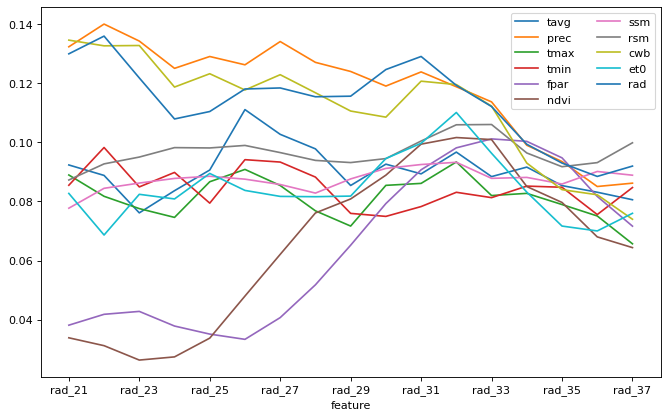

In [59]:
from matplotlib.pyplot import figure

figure(figsize=(10, 6), dpi=80)

for prefix in seq_feature_prefixes:
    mi_mean.loc[mi_mean['feature'].str.contains(prefix)].sort_values(by="feature").set_index("feature")["mean_mi"].rolling(3).mean().plot(label=prefix)
plt.legend(loc='upper right', ncol=2)

In [7]:
mutual_info_regression(train_df[["tavg_20", "prec_20"]], train_df["yield"])

array([0.09351906, 0.15419409])

### Model

In [66]:
unique_years = train_df['harvest_year'].unique()
unique_years.sort()
results = dict.fromkeys(unique_years)

seq_feature_prefixes = ["prec", "fpar", "ndvi", "cwb", "rad"]

batch_size = 32
num_epochs = 30
patience = 5

seq_input_size = len(seq_feature_prefixes)
static_input_size = len(static_features)
static_layer_1 = 100
static_layer_2 = 50
hidden_size = 100
lstm_layers = 2
dropout = 0.3
dense_size = 100
dense_size_1 = 100 
dense_size_2 = 100
output_size = 1


for year in unique_years:
    if (year not in [2022]): continue
    print(f'Validating on year {year}')
    train_fold_df =  train_df[ train_df['harvest_year'] != year].copy()
    val_fold_df =  train_df[ train_df['harvest_year'] == year].copy()
    train_fold_features = train_fold_df.drop(columns=['yield'])
    train_fold_target = train_fold_df['yield']
    val_fold_features = val_fold_df.drop(columns=['yield'])
    val_fold_target = val_fold_df['yield']
    
    means = train_fold_features.groupby(train_fold_features.index.get_level_values(0)).mean()
    stds = train_fold_features.groupby(train_fold_features.index.get_level_values(0)).std()
    means.loc[:, static_features] = 0
    stds.loc[:, static_features] = 1
    means_aligned =  means.reindex(val_fold_features.index)
    std_aligned = stds.reindex(val_fold_features.index)
    train_fold_features = (train_fold_features - means) / stds
    val_fold_features = (val_fold_features - means_aligned) / std_aligned

    seq_train_stacked, static_train = get_feature_arrays_for_lstm(train_fold_features, static_features, seq_feature_prefixes)
    seq_val_stacked, static_val = get_feature_arrays_for_lstm(val_fold_features, static_features, seq_feature_prefixes)
   
    #train_fold_dataset = CombinedDataset(seq_train_stacked, static_train, train_fold_target)
    #val_fold_dataset = CombinedDataset(seq_val_stacked, static_val, val_fold_target)
    train_fold_dataset = SequentialYieldPredictors(seq_train_stacked, train_fold_target)
    val_fold_dataset = SequentialYieldPredictors(seq_val_stacked, val_fold_target)
    
    train_fold_loader = DataLoader(train_fold_dataset, batch_size=batch_size, shuffle=True)
    val_fold_loader = DataLoader(val_fold_dataset, batch_size=batch_size, shuffle=False)
    
    # Reset the model and optimizer
    #model = CombinedModel(seq_input_size, static_input_size, static_layer_1, static_layer_2, hidden_size, lstm_layers, 
    #             dropout, dense_size_1, dense_size_2, output_size)
    model = LSTMRegression(seq_input_size, hidden_size, lstm_layers, dense_size, 1)
    optimizer = optim.Adadelta(model.parameters())
    criterion = RMSELoss
    print(count_parameters(model))
    
    # Early stopping parameters
    best_val_loss = float('inf')  # Initialize the best validation loss
    epochs_no_improve = 0  # Counter for epochs without improvement
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for features_dynamic, target in train_fold_loader:
            optimizer.zero_grad()
            output = model(features_dynamic)
            loss = criterion(output, target.unsqueeze(1))
            loss.backward()
            optimizer.step()
        
        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for features_dynamic, target in val_fold_loader:
                output = model(features_dynamic)
                loss = criterion(output, target.unsqueeze(1))
                val_loss += loss.item()
        
        val_loss /= len(val_fold_loader)  # Compute the average validation loss
        print(f'Epoch {epoch + 1}, Validation Loss for year {year}: {np.round(val_loss, 2)}')
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0  # Reset the counter if validation loss improves
        else:
            epochs_no_improve += 1  # Increment the counter if validation loss does not improve
        
        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break  # Stop training if no improvement for specified number of epochs
    
    results[year] = np.round(best_val_loss, 2)


Validating on year 2022
143901
Epoch 1, Validation Loss for year 2022: 28.92
Epoch 2, Validation Loss for year 2022: 30.69
Epoch 3, Validation Loss for year 2022: 32.78
Epoch 4, Validation Loss for year 2022: 28.9
Epoch 5, Validation Loss for year 2022: 29.12
Epoch 6, Validation Loss for year 2022: 32.0


KeyboardInterrupt: 

In [ ]:
results

{2003: 21.895093477689304,
 2004: 25.186617919376918,
 2005: 31.715064415564903,
 2007: 21.421781980074368,
 2008: 22.618428156926083,
 2009: 23.59405180124136,
 2010: 22.459916041447567,
 2011: 29.07908868789673,
 2012: 24.27490735054016,
 2013: 29.526430130004883,
 2014: 29.58192304464487,
 2016: 22.695734317486103,
 2018: 28.501761118570965,
 2019: 25.54012457529704,
 2020: 23.302857557932537,
 2021: 19.5442628126878,
 2022: 17.29091351372855}

In [11]:
results

{2003: 21.371985571725027,
 2004: 24.226039341517858,
 2005: 28.865666253226145,
 2007: 21.775109427315847,
 2008: 22.52009391784668,
 2009: 22.59456879752023,
 2010: 20.27269118172782,
 2011: 28.58042417253767,
 2012: 24.6958065032959,
 2013: 26.50239862714495,
 2014: 29.388872146606445,
 2016: 22.433117730276926,
 2018: 29.083726610456193,
 2019: 24.842851366315568,
 2020: 23.958420617239817,
 2021: 20.430754252842494,
 2022: 17.276971340179443}